# Créer des raport avec Python

Différentes approches :
- Pandas + Excel
- Pandas + HTML
- Dash

Chaque option a ses avantages et ses inconvénients. Elles demandent toutes un peu d'expérience en python mais permettent une automatisation très forte.


    

# Premier exemple : Pandas et Excel



In [17]:
import pandas as pd
import numpy as np

# on utilise notre dataframe
df = pd.read_sas("./data/bce_uai.sas7bdat", encoding='latin1')
df = pd.crosstab(df["DATE_OUVERTURE"].dt.month,df["SECTEUR_PUBLIC_PRIVE"], normalize = "columns", )

# On passe dans un classeur Excel
writer = pd.ExcelWriter('myreport.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Sheet1', startrow=2)

# On récupère les objets
book = writer.book
sheet = writer.sheets['Sheet1']

# Titre
bold = book.add_format({'bold': True, 'size': 24})
sheet.write('A1', 'Mon Rapport', bold)

# Color negative values in the DataFrame in red
format1 = book.add_format({'font_color': '#E93423'})
sheet.conditional_format('B4:C15', {'type': 'cell', 'criteria': '<=', 'value': 0.1, 'format': format1})

# Chart
chart = book.add_chart({'type': 'column'})
chart.add_series({'values': '=Sheet1!B4:B15', 'name': '=Sheet1!B3', 'categories': '=Sheet1!$A$4:$A$15'})
chart.add_series({'values': '=Sheet1!C4:C15', 'name': '=Sheet1!C3'})
sheet.insert_chart('A17', chart)

writer.save()

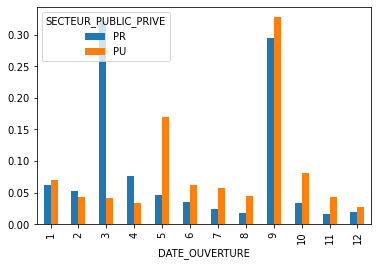

In [14]:
pd.crosstab(df["DATE_OUVERTURE"].dt.month,df["SECTEUR_PUBLIC_PRIVE"], normalize = "columns", ).plot.bar()

# Second exemple : Pandas et HTML

On crée un fichier template.html

On utilise pandas et jinja2

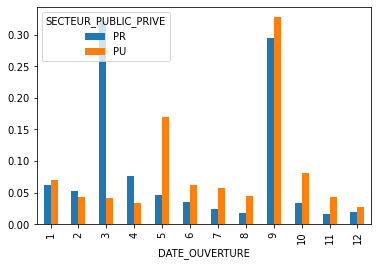

In [33]:
import pandas as pd
import numpy as np
import jinja2

# On récupère les données
df = pd.read_sas("./data/bce_uai.sas7bdat", encoding='latin1')
df = pd.crosstab(df["DATE_OUVERTURE"].dt.month,df["SECTEUR_PUBLIC_PRIVE"], normalize = "columns", )


def color_lessthan_red(val):
    color = 'red' if val < 0.1 else 'black'
    return f'color: {color}'

styler = df.style.applymap(color_negative_red)

# gestion du template
env = jinja2.Environment(loader=jinja2.FileSystemLoader(searchpath=''))
template = env.get_template('template.html')
html = template.render(my_table=styler.render())
# graphique
ax = df.plot.bar()
fig = ax.get_figure()
fig.savefig('plot.svg')

# ecriture du ficher html
with open('rapport_html.html', 'w') as f:
    f.write(html)

# Troisième exemple Dash



In [58]:
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# Sample DataFrame
# On récupère les données
df2 = pd.read_csv("effectifs-premier-degre.csv")
df2.Annee_scolaire = pd.to_numeric(df2.Annee_scolaire.str[:4])
df3 = df2.groupby(["Annee_scolaire","Libellé département"], as_index=False).agg({"Nombre_d_eleves":"sum", "Type d'établissement" : "count", "Academie":"first"})

# Dash app - The CSS code is pulled in from an external file
app = dash.Dash(__name__, external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])

# This defines the HTML layout
app.layout = html.Div([
    html.H1('My Report'),
    dcc.Graph(id='graph-with-slider'),
    dcc.Slider(
        id='year-slider',
        min=df3['Annee_scolaire'].min(),
        max=df3['Annee_scolaire'].max(),
        value=df3['Annee_scolaire'].min(),
        marks={str(year): str(year) for year in df3['Annee_scolaire'].unique()},
        step=None
    )
])

# This code runs every time the slider below the chart is changed
@app.callback(Output('graph-with-slider', 'figure'), [Input('year-slider', 'value')])
def update_figure(selected_year):
    filtered_df = df3[df3.Annee_scolaire == selected_year]
    traces = []
    for i in filtered_df.Academie.unique():
        df_by_continent = filtered_df[filtered_df['Academie'] == i]
        traces.append(dict(
            x=df_by_continent['Nombre_d_eleves'],
            y=df_by_continent["Type d'établissement"],
            text=df_by_continent['Libellé département'],
            mode='markers',
            opacity=0.7,
            marker={'size': 15, 'line': {'width': 0.5, 'color': 'white'}},
            name=i
        ))

    return {
        'data': traces,
        'layout': dict(
            xaxis={'title': "Nombre d'élèves", 'range': [0, df3["Nombre_d_eleves"].max()]},
            yaxis={'title': "Nombre d'établissements", 'range': [0, df3["Type d'établissement"].max()]},
            margin={'l': 40, 'b': 40, 't': 10, 'r': 10},
            legend={'x': 0, 'y': 1},
            hovermode='closest',
            transition={'duration': 500},
        )
    }

if __name__ == '__main__':
    app.run_server(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [08/Feb/2021 18:48:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:48:50] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:48:50] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:48:50] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:14] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:16] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:18] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:24] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [08/Feb/2021 18:49:32] "POST /_dash-update-component